# Explainable AI with Shapley Values: Linear Regression Example

This notebook demonstrates the fundamentals of **Shapley values** for explainable AI, following the methodology outlined in this [SHAP documentation article](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

## What are Shapley Values?

Shapley values are a unified framework for interpreting machine learning model predictions by quantifying each feature's contribution to individual predictions. Originally from cooperative game theory, they provide:

- **Fair attribution** of each feature's impact on model output
- **Model-agnostic explanations** that work across different algorithms  
- **Mathematically principled** approach with desirable properties (efficiency, symmetry, dummy, additivity)

Following this foundational understanding, we'll demonstrate these concepts through a practical machine learning application using linear regression as our starting point.

## Why Start with Linear Regression?

Linear regression provides the most intuitive introduction to Shapley values because:
- The relationship between features and predictions is transparent
- Shapley values have a direct connection to model coefficients
- Calculations are computationally straightforward
- Results are easily interpretable and verifiable

## Dataset and Objective

In the following cells, we'll:
1. Load the **California housing dataset** from the SHAP package (1,000 samples)
2. Train a linear regression model to predict the **natural log of median home prices**
3. Calculate and visualize Shapley values to understand feature contributions
4. Explore different SHAP visualization techniques

Let's begin by importing our dependencies and loading the data:

In [2]:
import ssl
import urllib.request

# Create an unverified SSL context to bypass certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

import sklearn
import shap
import matplotlib.pyplot as plt

# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


The goal of this notebook does not include exploratory data analysis. However, we will do some minimal exploration just to gain a better sense of the information contained in this dataset. We'll start with a preview of the data to show its feature names and some sampme values.

In [3]:
# print head of dataset
print(X.head())

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
14740  4.1518      22.0  5.663073   1.075472      1551.0  4.180593     32.58   
10101  5.7796      32.0  6.107226   0.927739      1296.0  3.020979     33.92   
20566  4.3487      29.0  5.930712   1.026217      1554.0  2.910112     38.65   
2670   2.4511      37.0  4.992958   1.316901       390.0  2.746479     33.20   
15709  5.0049      25.0  4.319261   1.039578       649.0  1.712401     37.79   

       Longitude  
14740    -117.05  
10101    -117.97  
20566    -121.84  
2670     -115.60  
15709    -122.43  


And we'll produce a simple histogram of the target variable, which is the natural log of the median home price.

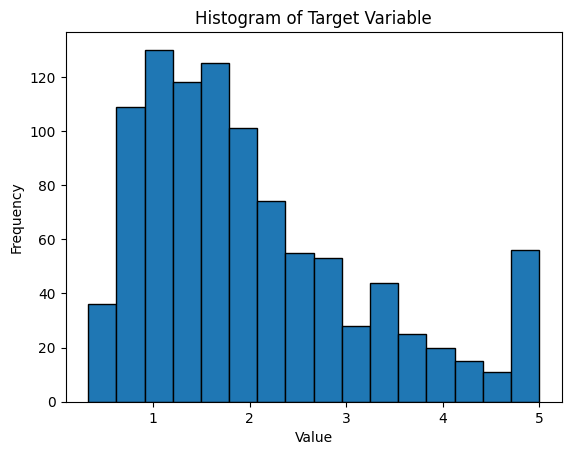

In [4]:
# print histogram of target variable
plt.hist(y, bins='auto', edgecolor='black') # 'auto' lets matplotlib choose optimal bins
plt.title('Histogram of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Model Training and Background Distribution

Now we'll prepare our data and train the linear regression model:

### Background Distribution Selection
First, we create a **background distribution** by sampling 100 instances from our dataset. This subset serves as a representative baseline for SHAP calculations:
- SHAP uses this background to compute expected values
- A smaller sample (100 vs 1000) makes computations more efficient
- The background represents "typical" feature values for comparison

### Linear Regression Model
We then train a simple linear regression model using scikit-learn:
- **Model**: `LinearRegression()` with default parameters
- **Training**: Fit on all 1,000 samples from the California housing dataset  
- **Target**: Predicting the natural log of median home prices
- **Features**: All 8 housing characteristics (income, age, rooms, etc.)

This straightforward approach gives us a baseline model whose predictions we can easily interpret and explain using Shapley values.

In [5]:
X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

## Model Coefficients

Now let's examine the **linear regression coefficients** to understand how each feature influences the predicted housing prices. In linear regression, each coefficient represents the **average change in the target variable** (log of median home price) for a one-unit increase in that feature, holding all other features constant.

### Coefficient Interpretation
- **Positive coefficients**: Features that increase housing prices
- **Negative coefficients**: Features that decrease housing prices  
- **Magnitude**: Larger absolute values may indicate stronger influence on predictions (This depends heavily on the scale of coefficients; see article for more details.)

This coefficient analysis provides our baseline understanding before we dive into Shapley values, which will show us how these linear relationships translate into feature contributions for individual predictions.

In [6]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Model coefficients:

MedInc = 0.42563
HouseAge = 0.01033
AveRooms = -0.1161
AveBedrms = 0.66385
Population = 3e-05
AveOccup = -0.26096
Latitude = -0.46734
Longitude = -0.46272


Before diving into SHAP values, let's visualize how our model behaves using a **partial dependence plot (PDP)**. This foundational visualization technique helps us understand the relationship between individual features and model predictions. A partial dependence plot shows the **marginal effect** of a feature on the predicted outcome by:
- Varying the target feature across its range
- Keeping all other features at their average values
- Plotting the resulting predictions

### Key Elements in This Plot:
- **Blue line**: Shows how median income (`MedInc`) affects predicted housing prices
- **Model expected value**: The horizontal reference line (average prediction across all data)
- **Feature expected value**: The vertical reference line (average median income value)
- **Gray Histogram**: Shows the distribution of median income in the background dataset.

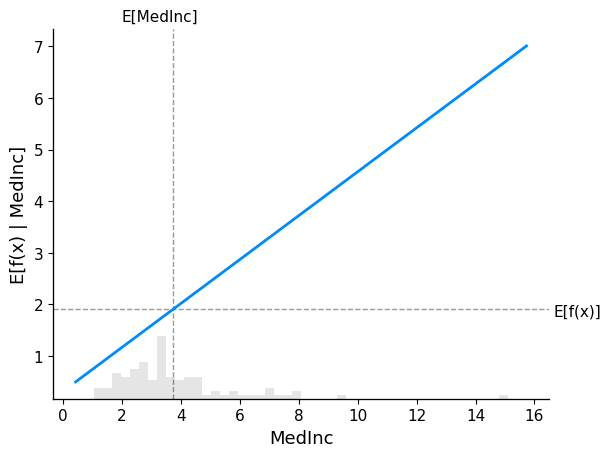

In [7]:
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In a linear regression model, Shapley values are easily read off of a partial dependence plot. 

In the next cell, we first create a SHAP explainer object that will compute Shapley values for our linear regression model:
- **Explainer**: Uses our trained model's `predict` method
- **Background**: Uses our 100-sample background distribution (X100) as the baseline (i.e. it represents the average feature values)
- **Computation**: Calculates SHAP values for all 1,000 instances in our dataset

### Individual Sample Focus
We then examine a specific instance (sample #30) to demonstrate how SHAP values work:
- **Sample selection**: `index = 30` chooses our example instance
- **Individual analysis**: Shows how this specific house's features contribute to its predicted price
- **Partial dependence with SHAP overlay**: The plot now includes both the global trend (blue line) and the specific sample's SHAP contribution

### Key Visualization Elements
In the enhanced partial dependence plot, you'll see:
- **Red Line**: The x-value represents the actual median income value for sample #30
- **SHAP contribution**: The length of the red line represents how much this feature contributes to the prediction for this specific house

This bridges the gap between understanding general model behavior and explaining individual predictions.

Median Income: X100["MedInc"] =  1.5774


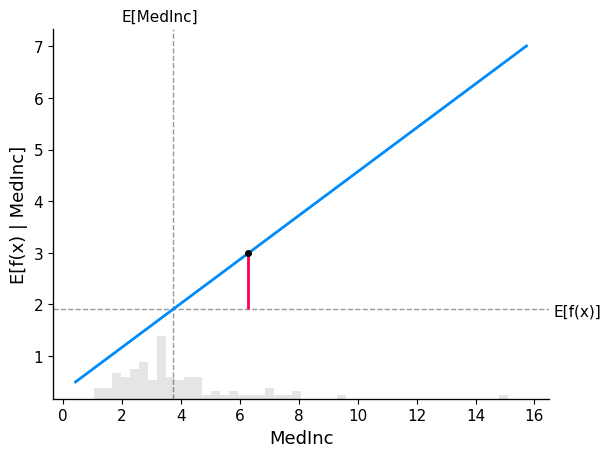

In [ ]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

index = 30
# print the Median Income for the selected index

# make a standard partial dependence plot
sample_ind = index
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)


Now we'll explore a **SHAP scatter plot** to understand how median income values relate to their corresponding SHAP contributions across all 1,000 instances in our dataset. A SHAP scatter plot visualizes the relationship between:
- **X-axis**: Actual feature values (median income in this case)
- **Y-axis**: SHAP values (feature contributions to individual predictions)
- **Each point**: Represents one house in our dataset

Note that the gray histograms now contains the whole dataset, not the background. This differentiates it from the partial dependence plot, which shows the baseline distribution used for SHAP calculations. 

### Key Insights to Look For:
- **Trend direction**: Does higher median income generally lead to higher SHAP values?
- **Linearity**: In linear regression, we expect a roughly linear relationship
- **Spread**: How much variation exists in SHAP contributions for similar feature values?
- **Outliers**: Are there instances where the typical pattern doesn't hold?

### Interpreting the Results:
- **Positive SHAP values**: Median income pushes the price prediction **above** the baseline
- **Negative SHAP values**: Median income pushes the price prediction **below** the baseline
- **Zero line**: Represents no contribution from this feature

This visualization helps us understand how consistently median income affects housing price predictions across our entire dataset.

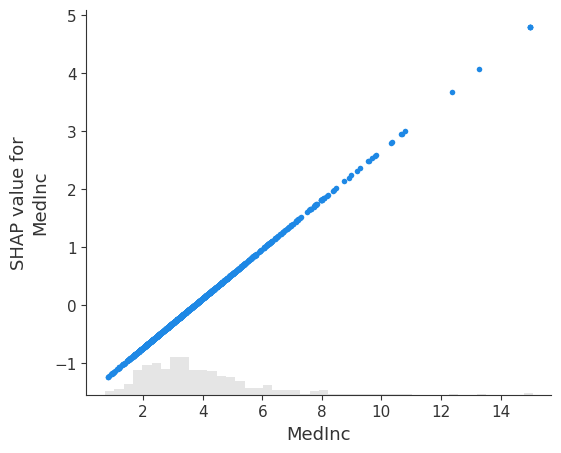

In [10]:
shap.plots.scatter(shap_values[:, "MedInc"])

## SHAP Waterfall Plot: Individual Prediction Breakdown

Finally, we'll use a **waterfall plot** to provide the most detailed explanation of how our model arrived at its prediction for sample #30.

### What is a SHAP Waterfall Plot?
The waterfall plot shows the step-by-step contribution of each feature to a single prediction:
- **Starting point**: The baseline/expected value (average model prediction)
- **Feature contributions**: How each feature pushes the prediction up or down
- **Final result**: The actual model prediction for this specific instance

### How to Read the Plot:
- **Baseline (E[f(X)])**: The expected model output (starting point)
- **Feature bars**: Each bar shows one feature's SHAP value
  - **Red bars**: Features that increase the prediction above baseline
  - **Blue bars**: Features that decrease the prediction below baseline
- **Final prediction (f(x))**: Where we end up after all contributions

### Mathematical Relationship:
The waterfall plot visualizes this key SHAP equation:
```
Baseline + Sum(All SHAP values) = Final Prediction
```

### Parameter Explanation:
- `max_display=14`: Shows up to 14 features (in this case, all 8 features fit)
- The plot automatically orders features by absolute contribution size

This gives us the most granular view of how each housing characteristic specifically influenced the price prediction for this individual house.

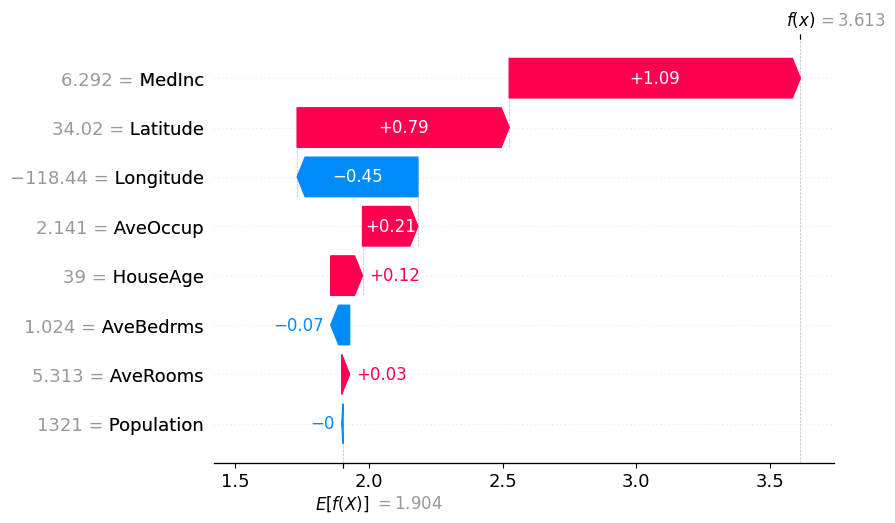

In [12]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)